In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [55]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)
    
class PolicyMonteCarlo(nn.Module):
    def __init__(self, num_guesses, num_actions):
        super(PolicyMonteCarlo, self).__init__()
        self.weights = torch.nn.Parameter(torch.rand((num_guesses, num_actions), dtype=float), requires_grad=True)
        #self.weights.require_grad = True
        self.x = torch.Tensor([1.0,1.0])
        
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        
        y = F.softmax(self.x.mul(self.weights[step_idx]), dim=0)
        #print(f'onehot {onehot}, step_idx {step_idx}')
        #print(self.weights)
        #print(self.weights[step_idx])
        #print(y)
        return y
        

In [49]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [50]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [44]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

def optimize_model_single(model, optimizer, state, action, reward):
        
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [66]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    elif model.name == 'monte':
        policy_net = PolicyMonteCarlo(env.num_guesses, len(policy_helper.actions)).to(device)
        print('monte weights')
        print(policy_net.weights)
        print(F.softmax(policy_net.weights, dim=1))
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
        
    if training.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    elif training.optimizer == 'sgd':
        optimizer = optim.SGD(policy_net.parameters(), lr=training.lr)
    else:
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)
        
    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for tr in episode_memory:
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                        
                    if model.name == 'monte':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

monte weights
Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)
tensor([[0.4592, 0.5408],
        [0.5143, 0.4857],
        [0.6098, 0.3902],
        [0.4385, 0.5615],
        [0.5208, 0.4792],
        [0.5451, 0.4549]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
pn params [Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 badly-------
reward -1 done False action 0
------guess 2 0 mangy-------
reward -1 done False action 0
------guess 3 0 canny-------
reward -1 done False action 0
------guess 4 1 whips-------
r

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 wager-------
reward -1 done False action 0
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 1 bifid-------
reward -1 done False action 1
------guess 5 0 rarer-------
reward 0 done True action 0
episode 18 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.33965971929501715  steps 84  memory 78
=========================episode 19 loser======================
------guess 0 0 court-------
reward -1 done False action 0
------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 1 nymph-------
reward -1 done False action 1
------guess 3 1 budge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 loser-------
reward 0 done True action 0
episode 19 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 84
=========================epi

------guess 5 1 flock-------
reward -1 done True action 1
episode 36 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5661255185670091  steps 168  memory 162
=========================episode 37 fewer======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 rebel-------
reward -1 done False action 0
------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 0 defer-------
reward -1 done False action 0
------guess 4 0 fever-------
reward -1 done False action 0
------guess 5 0 fewer-------
reward 0 done True action 0
episode 37 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.5789484473726788  steps 174  memory 168
=========================episode 38 graft======================
------guess 0 0 ahead-------
reward -1 done False action 0
------guess 1 1 lirot-------
reward -1 done False action 1
------guess 2 0 tract-------
reward -1 done False action 0
------guess 3 0 grant-------
reward -1 done False action 0
------guess 4 0 graf

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 dodgy-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 1 nymph-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 1 fives-------
reward -1 done True action 1
episode 55 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7191683782216203  steps 255  memory 25
=========================episode 56 mouth======================
------guess 0 0 lurid-------
reward -1 done False action 0
------guess 1 1 stoae-------
reward -1 done False action 1
------guess 2 0 mount-------
reward -1 done False action 0
------guess 3 0 mouth-------
reward 0 done True action 0
episode 56 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7247292169102477  steps 259  memory 31
=========================episode 57 showy======================
------guess 0 0 utile-------
reward -1 done False action 0
------guess 1 1 roans-

------guess 1 1 linos-------
reward -1 done False action 1
------guess 2 0 feral-------
reward 0 done True action 0
episode 73 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8227155900301222  steps 347  memory 120
=========================episode 74 tatty======================
------guess 0 0 slurp-------
reward -1 done False action 0
------guess 1 1 atone-------
reward -1 done False action 1
------guess 2 1 dicky-------
reward -1 done False action 1
------guess 3 1 might-------
reward -1 done False action 1
------guess 4 0 tabby-------
reward -1 done False action 0
------guess 5 0 tatty-------
reward 0 done True action 0
episode 74 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8279551361769495  steps 353  memory 123
=========================episode 75 moron======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 world-------
reward -1 done False action 0
------guess 2 0 forum-------
reward -1 done False action 0
------guess 3 0 morph

------guess 4 0 savvy-------
reward -1 done False action 0
------guess 5 0 sappy-------
reward -1 done True action 0
episode 92 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.8852500654027212  steps 434  memory 204
=========================episode 93 quash======================
------guess 0 0 spasm-------
reward -1 done False action 0
------guess 1 0 boast-------
reward -1 done False action 0
------guess 2 0 cease-------
reward -1 done False action 0
------guess 3 0 quash-------
reward 0 done True action 0
episode 93 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8875222663457104  steps 438  memory 210
=========================episode 94 minus======================
------guess 0 0 fluke-------
reward -1 done False action 0
------guess 1 1 ariot-------
reward -1 done False action 1
------guess 2 0 cumin-------
reward -1 done False action 0
------guess 3 0 minus-------
reward 0 done True action 0
episode 94 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8897494746955148  

------guess 2 1 lindy-------
reward -1 done False action 1
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 0 irony-------
reward 0 done True action 0
episode 110 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9242259959771545  steps 517  memory 0
=========================episode 111 feral======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 pearl-------
reward -1 done False action 0
------guess 3 0 feral-------
reward 0 done True action 0
episode 111 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9257264217856661  steps 521  memory 5
=========================episode 112 teary======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 irate-------
reward -1 done False action 0
------guess 2 0 heart-------
reward -1 done False action 0
------guess 3 1 lungs-------
reward -1 done False action 1
------guess 4 1 campy

------guess 1 1 tails-------
reward -1 done False action 1
------guess 2 1 punch-------
reward -1 done False action 1
------guess 3 1 womby-------
reward -1 done False action 1
------guess 4 0 bleat-------
reward 0 done True action 0
episode 128 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9499633729134137  steps 600  memory 51
=========================episode 129 grove======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 drone-------
reward -1 done False action 0
------guess 2 0 prove-------
reward -1 done False action 0
------guess 3 1 sulci-------
reward -1 done False action 1
------guess 4 0 grove-------
reward 0 done True action 0
episode 129 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.951198781637987  steps 605  memory 56
=========================episode 130 bugle======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 glide-------
reward -1 done False action 0
------guess 2 1 sync

------guess 3 0 agony-------
reward 0 done True action 0
episode 146 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9682543636219321  steps 691  memory 143
=========================episode 147 mafia======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 vapid-------
reward -1 done False action 0
------guess 3 0 maxim-------
reward -1 done False action 0
------guess 4 0 mafia-------
reward 0 done True action 0
episode 147 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9690381661768231  steps 696  memory 147
=========================episode 148 smart======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 apart-------
reward -1 done False action 0
------guess 2 0 start-------
reward -1 done False action 0
------guess 3 1 linch-------
reward -1 done False action 1
------guess 4 1 fudgy-------
reward -1 done False action 1
------guess 5 1 k

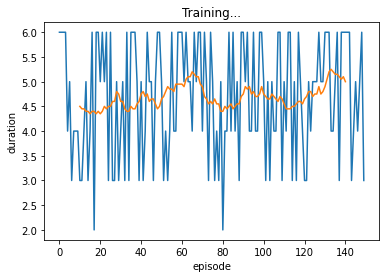

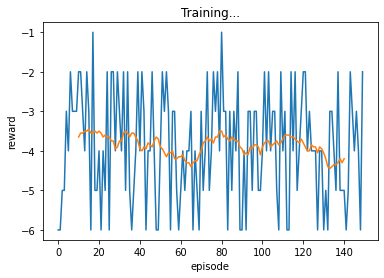

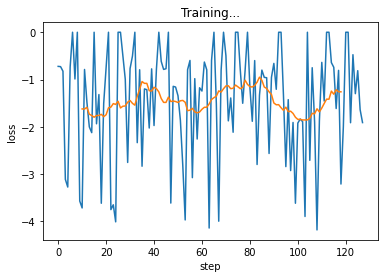

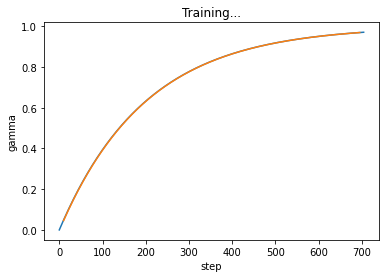

In [67]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=150,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=32, train_interval=32, clear_memory=True),
    seed=1
    ))

pn params [Parameter containing:
tensor([[0.0611, 0.2246],
        [0.2343, 0.1771],
        [0.5561, 0.1094],
        [0.4609, 0.7084],
        [0.5798, 0.4967],
        [0.5104, 0.3295]], dtype=torch.float64, requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 badly-------
reward -1 done False action 0
------guess 2 0 mangy-------
reward -1 done False action 0
------guess 3 0 canny-------
reward -1 done False action 0
------guess 4 1 whips-------
reward -1 done False action 1
------guess 5 0 fanny-------
reward -1 done True action 0
episode 0 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 store======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 

------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 1 nymph-------
reward -1 done False action 1
------guess 3 1 budge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 loser-------
reward 0 done True action 0
episode 19 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.35917572396768127  steps 90  memory 84
=========================episode 20 tripe======================
------guess 0 0 koala-------
reward -1 done False action 0
------guess 1 1 resit-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 0 tripe-------
reward 0 done True action 0
episode 20 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3749977317172992  steps 95  memory 90
=========================episode 21 verge======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin---

------guess 1 0 liege-------
reward -1 done False action 0
------guess 2 0 girly-------
reward 0 done True action 0
episode 39 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5954581148969812  steps 182  memory 179
=========================episode 40 flint======================
------guess 0 0 union-------
reward -1 done False action 0
------guess 1 1 artel-------
reward -1 done False action 1
------guess 2 0 glint-------
reward -1 done False action 0
------guess 3 1 psych-------
reward -1 done False action 1
------guess 4 0 flint-------
reward 0 done True action 0
episode 40 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.605446289628399  steps 187  memory 182
=========================episode 41 denim======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 denim-------
reward 0 done True action 0
episode 41 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.611320429098247  ste

------guess 2 1 leuco-------
reward -1 done False action 1
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0 plank-------
reward 0 done True action 0
episode 57 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.735522738700176  steps 267  memory 38
=========================episode 58 digit======================
------guess 0 0 aorta-------
reward -1 done False action 0
------guess 1 0 etude-------
reward -1 done False action 0
------guess 2 0 ditch-------
reward -1 done False action 0
------guess 3 0 digit-------
reward 0 done True action 0
episode 58 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7407597393541085  steps 271  memory 43
=========================episode 59 evade======================
------guess 0 0 chess-------
reward -1 done False action 0
------guess 1 1 rotal-------
reward -1 done False action 1
------guess 2 1 duing-------
reward -1 done False action 1
------guess 3 1 bumpy-------
reward -1 done False action 1
------guess 4 1 wakfs---

------guess 4 0 slick-------
reward 0 done True action 0
episode 75 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.833872547653167  steps 360  memory 131
=========================episode 76 caulk======================
------guess 0 0 taken-------
reward -1 done False action 0
------guess 1 0 caulk-------
reward 0 done True action 0
episode 76 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.8355255434228451  steps 362  memory 136
=========================episode 77 flank======================
------guess 0 0 piper-------
reward -1 done False action 0
------guess 1 0 flask-------
reward -1 done False action 0
------guess 2 0 flank-------
reward 0 done True action 0
episode 77 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8379742490661193  steps 365  memory 138
=========================episode 78 grunt======================
------guess 0 0 steel-------
reward -1 done False action 0
------guess 1 0 datum-------
reward -1 done False action 0
------guess 2 0 pouty-------
rewar

------guess 3 1 munch-------
reward -1 done False action 1
------guess 4 0 seven-------
reward 0 done True action 0
episode 93 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8902993514844886  steps 443  memory 22
=========================episode 94 goose======================
------guess 0 0 eight-------
reward -1 done False action 0
------guess 1 0 adage-------
reward -1 done False action 0
------guess 2 1 lours-------
reward -1 done False action 1
------guess 3 1 poncy-------
reward -1 done False action 1
------guess 4 0 goose-------
reward 0 done True action 0
episode 94 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8930078701468855  steps 448  memory 27
monte weights
Parameter containing:
tensor([[ 0.9502, -0.6646],
        [ 0.1823,  0.2290],
        [ 0.5291,  0.1364],
        [-0.0134,  1.1826],
        [ 1.1325, -0.0560],
        [ 0.6821,  0.1579]], dtype=torch.float64, requires_grad=True)
tensor([[0.8341, 0.1659],
        [0.4883, 0.5117],
        [0.5969, 0.4031],

------guess 3 1 abohm-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 cezve-------
reward -1 done True action 1
episode 110 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9286387304436139  steps 529  memory 75
=========================episode 111 liken======================
------guess 0 0 house-------
reward -1 done False action 0
------guess 1 1 trial-------
reward -1 done False action 1
------guess 2 1 dancy-------
reward -1 done False action 1
------guess 3 1 gramp-------
reward -1 done False action 1
------guess 4 0 liken-------
reward 0 done True action 0
episode 111 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9304006464667309  steps 534  memory 81
=========================episode 112 voice======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 poesy-------
reward -1 done False action 0
------guess 2 0 booze-------
reward -1 done False action 0
------guess 3 0 vo

reward -1 done False action 0
------guess 1 0 mummy-------
reward -1 done False action 0
------guess 2 0 quash-------
reward -1 done False action 0
------guess 3 1 tenor-------
reward -1 done False action 1
------guess 4 0 super-------
reward -1 done False action 0
------guess 5 1 aback-------
reward -1 done True action 1
episode 129 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9531123047800115  steps 613  memory 31
=========================episode 130 batch======================
------guess 0 0 level-------
reward -1 done False action 0
------guess 1 1 ratio-------
reward -1 done False action 1
------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 0 catch-------
reward -1 done False action 0
------guess 4 1 dumps-------
reward -1 done False action 1
------guess 5 0 batch-------
reward 0 done True action 0
episode 130 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9544980455953784  steps 619  memory 37
=========================episode 131 grape===========

------guess 2 0 chord-------
reward -1 done False action 0
------guess 3 1 napes-------
reward -1 done False action 1
------guess 4 0 chard-------
reward 0 done True action 0
episode 147 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9693462415707943  steps 698  memory 21
=========================episode 148 awful======================
------guess 0 0 peach-------
reward -1 done False action 0
------guess 1 1 triol-------
reward -1 done False action 1
------guess 2 0 awful-------
reward 0 done True action 0
episode 148 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9698026165776815  steps 701  memory 26
=========================episode 149 creek======================
------guess 0 0 fizzy-------
reward -1 done False action 0
------guess 1 1 oater-------
reward -1 done False action 1
------guess 2 1 shuln-------
reward -1 done False action 1
------guess 3 1 pudic-------
reward -1 done False action 1
------guess 4 0 creek-------
reward 0 done True action 0
episode 149 finished.

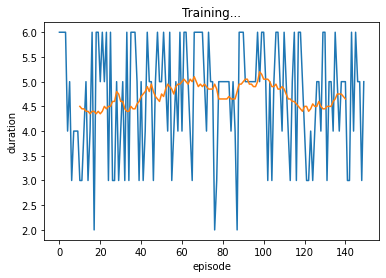

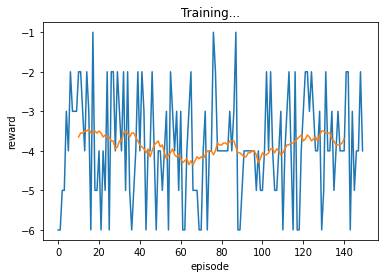

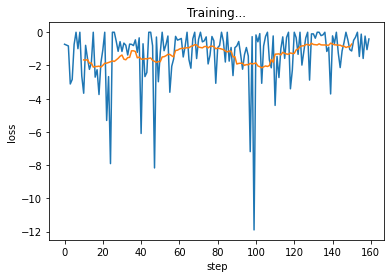

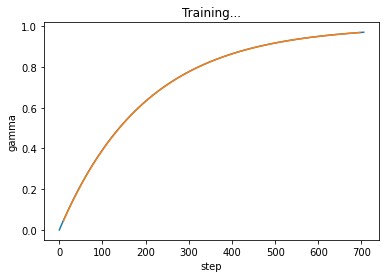

In [65]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=150,
    training=TrainConfig(optimizer='sgd', lr=0.1, batch_size=32, train_interval=32, clear_memory=True),
    seed=1
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 1 store-------
reward -1 done False action 1
------guess 2 0 offal-------
reward 0 done True action 0
episode 13 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.2628766256083722  steps 62  memory 59
=========================episode 14 salve======================
------guess 0 0 crimp-------
reward -1 done False action 0
------guess 1 0 tense-------
reward -1 done False action 0
------guess 2 0 shake-------
reward -1 done False action 0
------guess 3 1 godly-------
reward -1 done False action 1
------guess 4 0 salve-------
reward 0 done True action 0
episode 14 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.28107626656807383  steps 67  memory 62
=========================episode 15 snack======================
------guess 0 0 solar-------
reward -1 done False action 0
------guess 1 1 untie-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 pygmy-------
reward -1 done False action 1
------guess 4 0 snack---

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 heart-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 trace-------
reward -1 done False action 0
------guess 4 1 umped-------
reward -1 done False action 1
------guess 5 1 befog-------
reward -1 done True action 1
episode 32 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5415939886947765  steps 157  memory 151
=========================episode 33 spunk======================
------guess 0 0 mover-------
reward -1 done False action 0
------guess 1 1 litas-------
reward -1 done False action 1
------guess 2 0 bushy-------
reward -1 done False action 0
------guess 3 1 pwned-------
reward -1 done False action 1
------guess 4 1 gecks-------
reward -1 done False action 1
------guess 5 0 spunk-------
reward 0 done True action 0
episode 33 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.5551419337770589  steps 163  memory 157
=========================

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bilge-------
reward -1 done False action 0
------guess 3 0 bible-------
reward 0 done True action 0
episode 51 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7047698330759857  steps 245  memory 241
=========================episode 52 frown======================
------guess 0 0 shelf-------
reward -1 done False action 0
------guess 1 0 foggy-------
reward -1 done False action 0
------guess 2 1 intra-------
reward -1 done False action 1
------guess 3 0 frown-------
reward 0 done True action 0
episode 52 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7106157820609493  steps 249  memory 245
=========================episode 53 poesy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 felon-------
reward -1 done False action 0
------guess 2 1 scudi-------
reward -1 done False action 1
------guess 3 1 nymph

------guess 1 1 roils-------
reward -1 done False action 1
------guess 2 1 munch-------
reward -1 done False action 1
------guess 3 1 gawky-------
reward -1 done False action 1
------guess 4 1 bufos-------
reward -1 done False action 1
------guess 5 0 tutor-------
reward 0 done True action 0
episode 69 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8117529343612532  steps 335  memory 9
=========================episode 70 pupil======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 begad-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 pupil-------
reward 0 done True action 0
episode 70 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8173164759472653  steps 341  memory 15
=========================episode 71 mucky======================
------guess 0 1 oater---

------guess 2 1 dunch-------
reward -1 done False action 1
------guess 3 0 argue-------
reward -1 done False action 0
------guess 4 0 azure-------
reward 0 done True action 0
episode 88 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8799683714885432  steps 425  memory 68
=========================episode 89 fritz======================
------guess 0 0 quart-------
reward -1 done False action 0
------guess 1 0 forte-------
reward -1 done False action 0
------guess 2 0 fritz-------
reward 0 done True action 0
episode 89 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8817554096233645  steps 428  memory 73
=========================episode 90 urine======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 urine-------
reward 0 done True action 0
episode 90 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.883515842226503  steps 431  memory 76
=========================episode 91 scamp=

------guess 3 1 talcy-------
reward -1 done False action 1
------guess 4 0 avert-------
reward 0 done True action 0
episode 108 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.920340979714102  steps 507  memory 150
=========================episode 109 arena======================
------guess 0 0 gooey-------
reward -1 done False action 0
------guess 1 0 amuse-------
reward -1 done False action 0
------guess 2 0 alert-------
reward -1 done False action 0
------guess 3 0 arena-------
reward 0 done True action 0
episode 109 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9219183339988468  steps 511  memory 155
=========================episode 110 leafy======================
------guess 0 0 theme-------
reward -1 done False action 0
------guess 1 0 rower-------
reward -1 done False action 0
------guess 2 0 glaze-------
reward -1 done False action 0
------guess 3 0 leaky-------
reward -1 done False action 0
------guess 4 0 leafy-------
reward 0 done True action 0
episode 110 finished

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 evoke-------
reward 0 done True action 0
episode 129 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9494604964508653  steps 598  memory 242
=========================episode 130 hotel======================
------guess 0 0 spend-------
reward -1 done False action 0
------guess 1 0 table-------
reward -1 done False action 0
------guess 2 1 curio-------
reward -1 done False action 1
------guess 3 0 motel-------
reward -1 done False action 0
------guess 4 0 hotel-------
reward 0 done True action 0
episode 130 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9507083212395379  steps 603  memory 246
=========================episode 131 snoop======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 c

------guess 1 0 which-------
reward -1 done False action 0
------guess 2 0 clack-------
reward -1 done False action 0
------guess 3 0 aback-------
reward 0 done True action 0
episode 149 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9672875650609802  steps 685  memory 41
Complete


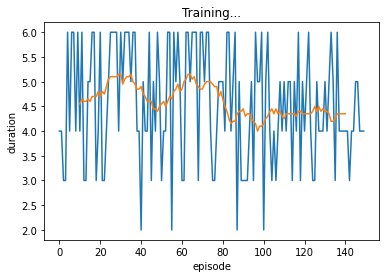

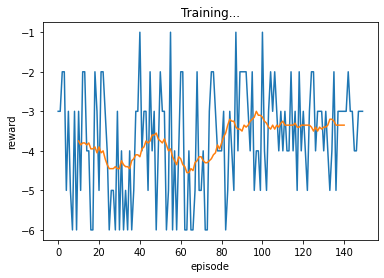

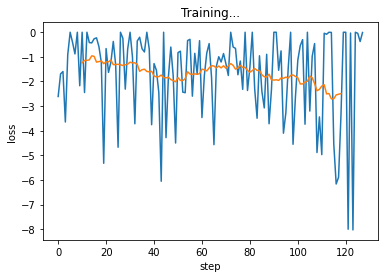

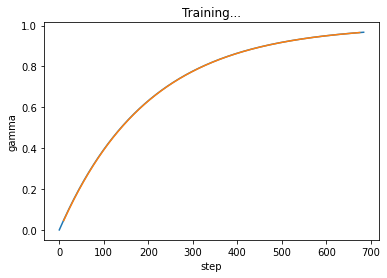

In [16]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.009, batch_size=32, train_interval=32, clear_memory=True)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 1 store-------
reward -1 done False action 1
------guess 2 0 offal-------
reward 0 done True action 0
episode 13 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.2628766256083722  steps 62  memory 59
=========================episode 14 salve======================
------guess 0 0 crimp-------
reward -1 done False action 0
------guess 1 0 tense-------
reward -1 done False action 0
------guess 2 0 shake-------
reward -1 done False action 0
------guess 3 1 godly-------
reward -1 done False action 1
------guess 4 0 salve-------
reward 0 done True action 0
episode 14 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.28107626656807383  steps 67  memory 62
=========================episode 15 snack======================
------guess 0 0 solar-------
reward -1 done False action 0
------guess 1 1 untie-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 pygmy-------
reward -1 done False action 1
------guess 4 0 snack---

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 heart-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 trace-------
reward -1 done False action 0
------guess 4 1 umped-------
reward -1 done False action 1
------guess 5 1 befog-------
reward -1 done True action 1
episode 32 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5415939886947765  steps 157  memory 151
=========================episode 33 spunk======================
------guess 0 0 mover-------
reward -1 done False action 0
------guess 1 1 litas-------
reward -1 done False action 1
------guess 2 0 bushy-------
reward -1 done False action 0
------guess 3 1 pwned-------
reward -1 done False action 1
------guess 4 1 gecks-------
reward -1 done False action 1
------guess 5 0 spunk-------
reward 0 done True action 0
episode 33 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.5551419337770589  steps 163  memory 157
=========================

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bilge-------
reward -1 done False action 0
------guess 3 0 bible-------
reward 0 done True action 0
episode 51 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7047698330759857  steps 245  memory 241
=========================episode 52 frown======================
------guess 0 0 shelf-------
reward -1 done False action 0
------guess 1 0 foggy-------
reward -1 done False action 0
------guess 2 1 intra-------
reward -1 done False action 1
------guess 3 0 frown-------
reward 0 done True action 0
episode 52 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7106157820609493  steps 249  memory 245
=========================episode 53 poesy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 felon-------
reward -1 done False action 0
------guess 2 1 scudi-------
reward -1 done False action 1
------guess 3 1 nymph

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 begad-------
reward -1 done False action 1
------guess 4 0 matey-------
reward 0 done True action 0
episode 71 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8117529343612532  steps 335  memory 330
=========================episode 72 savor======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gibed-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 savor-------
reward 0 done True action 0
episode 72 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8173164759472653  steps 341  memory 335
=========================episode 73 adept======================
------guess 0 1 orate

------guess 1 1 ratio-------
reward -1 done False action 1
------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 0 caulk-------
reward 0 done True action 0
episode 89 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.883515842226503  steps 431  memory 427
=========================episode 90 snore======================
------guess 0 0 pried-------
reward -1 done False action 0
------guess 1 1 altos-------
reward -1 done False action 1
------guess 2 0 shore-------
reward -1 done False action 0
------guess 3 0 swore-------
reward -1 done False action 0
------guess 4 1 bungy-------
reward -1 done False action 1
------guess 5 0 snore-------
reward 0 done True action 0
episode 90 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8869584693595501  steps 437  memory 431
=========================episode 91 grand======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 crank-

------guess 2 0 shrew-------
reward -1 done False action 0
------guess 3 1 pudic-------
reward -1 done False action 1
------guess 4 0 press-------
reward 0 done True action 0
episode 108 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9260968628024441  steps 522  memory 517
=========================episode 109 manga======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 begad-------
reward -1 done False action 1
------guess 4 0 manga-------
reward 0 done True action 0
episode 109 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9279215377612339  steps 527  memory 522
=========================episode 110 bloat======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 float-------
reward -1 done False action 0
------guess 2 0 bloat-------
reward 0 done True action 0
episode 110 finishe

------guess 1 1 realo-------
reward -1 done False action 1
------guess 2 0 pithy-------
reward -1 done False action 0
------guess 3 1 cundy-------
reward -1 done False action 1
------guess 4 0 fight-------
reward -1 done False action 0
------guess 5 0 might-------
reward 0 done True action 0
episode 128 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9531123047800115  steps 613  memory 607
=========================episode 129 diary======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 grand-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 1 nymph-------
reward -1 done False action 1
------guess 4 0 diary-------
reward 0 done True action 0
episode 129 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9542699660997818  steps 618  memory 613
=========================episode 130 visor======================
------guess 0 0 amity-------
reward -1 done False action 0
------guess 1 1 s

------guess 1 1 olein-------
reward -1 done False action 1
------guess 2 0 merit-------
reward 0 done True action 0
episode 147 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9691925889672489  steps 697  memory 694
=========================episode 148 exult======================
------guess 0 0 birth-------
reward -1 done False action 0
------guess 1 0 leant-------
reward -1 done False action 0
------guess 2 1 doucs-------
reward -1 done False action 1
------guess 3 0 exult-------
reward 0 done True action 0
episode 148 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9698026165776815  steps 701  memory 697
=========================episode 149 swear======================
------guess 0 0 roomy-------
reward -1 done False action 0
------guess 1 0 whirl-------
reward -1 done False action 0
------guess 2 1 etnas-------
reward -1 done False action 1
------guess 3 1 cupid-------
reward -1 done False action 1
------guess 4 0 swear-------
reward 0 done True action 0
episode 149 finishe

------guess 1 0 flour-------
reward -1 done False action 0
------guess 2 0 sport-------
reward -1 done False action 0
------guess 3 0 brown-------
reward -1 done False action 0
------guess 4 0 broom-------
reward -1 done False action 0
------guess 5 1 chive-------
reward -1 done True action 1
episode 165 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9806487836303224  steps 790  memory 784
=========================episode 166 agent======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 valet-------
reward -1 done False action 0
------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 0 agent-------
reward 0 done True action 0
episode 166 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.98103196338757  steps 794  memory 790
=========================episode 167 orbit======================
------guess 0 0 going-------
reward -1 done False action 0
------guess 1 1 later-------
reward -1 done False action 1
------guess 2 0 dr

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 storm-------
reward -1 done False action 0
------guess 3 1 dunch-------
reward -1 done False action 1
------guess 4 0 short-------
reward 0 done True action 0
episode 185 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9876611196745695  steps 880  memory 875
=========================episode 186 frost======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 frost-------
reward 0 done True action 0
episode 186 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9879054458749221  steps 884  memory 880
=========================episode 187 among======================
------guess 0 0 smart-------
reward -1 done False action 0
------guess 1 0 omega-------
reward -1 done False action 0
------guess 2 1 l

------guess 2 0 binge-------
reward -1 done False action 0
------guess 3 0 hinge-------
reward 0 done True action 0
episode 203 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9921716224507742  steps 971  memory 967
=========================episode 204 inlet======================
------guess 0 0 quake-------
reward -1 done False action 0
------guess 1 1 triol-------
reward -1 done False action 1
------guess 2 0 inlet-------
reward 0 done True action 0
episode 204 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9922881718085371  steps 974  memory 971
=========================episode 205 heavy======================
------guess 0 0 odder-------
reward -1 done False action 0
------guess 1 1 alist-------
reward -1 done False action 1
------guess 2 1 punch-------
reward -1 done False action 1
------guess 3 1 womby-------
reward -1 done False action 1
------guess 4 0 heavy-------
reward 0 done True action 0
episode 205 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.99247857752500

------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 1 nymph-------
reward -1 done False action 1
------guess 4 0 snowy-------
reward 0 done True action 0
episode 223 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9949833856245097  steps 1060  memory 1055
=========================episode 224 start======================
------guess 0 0 quart-------
reward -1 done False action 0
------guess 1 0 chart-------
reward -1 done False action 0
------guess 2 0 start-------
reward 0 done True action 0
episode 224 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9950580732823202  steps 1063  memory 1060
=========================episode 225 tepee======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 tepee-------
reward 0 done True action 0
episode 225 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9951559299

------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 badge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 avize-------
reward -1 done True action 1
episode 242 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9967366467240238  steps 1146  memory 1140
=========================episode 243 speed======================
------guess 0 0 write-------
reward -1 done False action 0
------guess 1 0 expel-------
reward -1 done False action 0
------guess 2 1 canso-------
reward -1 done False action 1
------guess 3 1 fudgy-------
reward -1 done False action 1
------guess 4 0 speed-------
reward 0 done True action 0
episode 243 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9968172192034903  steps 1151  memory 1146
=========================episode 244 sweep======================
------guess 0 0 flush-------
reward -1 done False action 0
------guess 1 0 taste-------
reward -1 done False action 0
------guess 

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 newer-------
reward 0 done True action 0
episode 260 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9979087639994849  steps 1235  memory 1231
=========================episode 261 swish======================
------guess 0 0 godly-------
reward -1 done False action 0
------guess 1 0 paper-------
reward -1 done False action 0
------guess 2 1 inust-------
reward -1 done False action 1
------guess 3 0 whisk-------
reward -1 done False action 0
------guess 4 1 combs-------
reward -1 done False action 1
------guess 5 0 swish-------
reward 0 done True action 0
episode 261 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9979705693637043  steps 1241  memory 1235
=========================episode 262 guise======================
------guess 0 0 aging-------
reward -1 done False action 0
------guess 1

------guess 2 1 dungs-------
reward -1 done False action 1
------guess 3 1 womby-------
reward -1 done False action 1
------guess 4 0 built-------
reward 0 done True action 0
episode 278 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.998673219568973  steps 1326  memory 1321
=========================episode 279 jolly======================
------guess 0 0 shelf-------
reward -1 done False action 0
------guess 1 0 quilt-------
reward -1 done False action 0
------guess 2 0 manly-------
reward -1 done False action 0
------guess 3 0 wryly-------
reward -1 done False action 0
------guess 4 0 dolly-------
reward -1 done False action 0
------guess 5 1 pubco-------
reward -1 done True action 1
episode 279 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9987124318567103  steps 1332  memory 1326
=========================episode 280 gnash======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 small-------
reward -1 done False action 0
------guess 2

------guess 1 0 album-------
reward -1 done False action 0
------guess 2 0 quasi-------
reward -1 done False action 0
------guess 3 0 squad-------
reward 0 done True action 0
episode 297 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999136917262916  steps 1412  memory 0
=========================episode 298 rumba======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 scram-------
reward -1 done False action 0
------guess 2 0 drama-------
reward -1 done False action 0
------guess 3 0 rumba-------
reward 0 done True action 0
episode 298 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9991540074461563  steps 1416  memory 4
=========================episode 299 count======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 donut-------
reward -1 done False action 0
------guess 2 0 count-------
reward 0 done True action 0
episode 299 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9991666026343933 

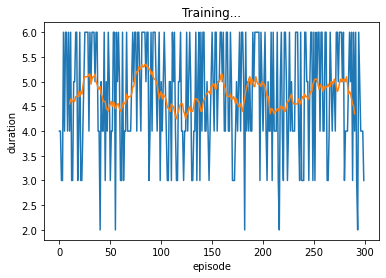

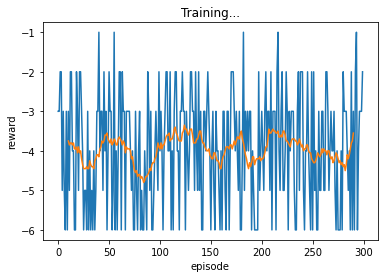

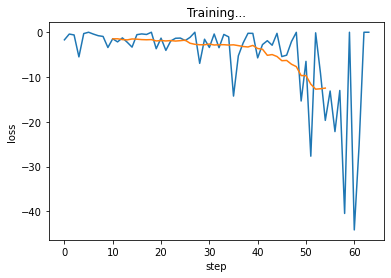

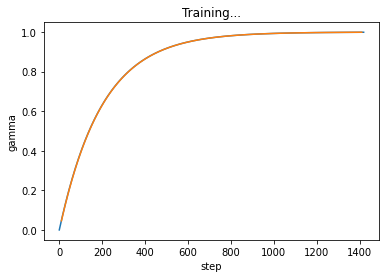

In [15]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=300,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=64, train_interval=64, clear_memory=True)
    ))